## Compare transports between control and basal/iceberg experiments

Used some of Adele's scripts to calculate the transport in sigma 0 coordinates over the 1000m isobath. The scripts are located in the folder `PBS-script-code`. These are run each month and the output is in `/g/data/x77/cy8964/Post_Process/access-om2/##EXPT##` in monthly files. 

Recommend a XXLarge ARE session on Gadi if generating the compiled netcdf files for the first time.

In [1]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import netCDF4 as nc
import xarray as xr
import numpy as np
from dask.distributed import Client
import cmocean as cm
from matplotlib import gridspec
from collections import OrderedDict


In [2]:
client = Client(n_workers=4)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/44919/status,
Dashboard: /proxy/44919/status,Workers: 4
Total threads: 16,Total memory: 63.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:41835,Workers: 4
Dashboard: /proxy/44919/status,Total threads: 16
Started: Just now,Total memory: 63.00 GiB
Comm: tcp://127.0.0.1:39027,Total threads: 4
Dashboard: /proxy/35467/status,Memory: 15.75 GiB
Nanny: tcp://127.0.0.1:42741,


### Make database

In [3]:
# database for control simulation:
session_name = '/g/data/v45/wf4500/databases/gdata_01deg_jra55v13_ryf9091_DSW.db'
# master_session = cc.database.create_session(session_name)
#session_name = '/home/156/wf4500/databases/access/DSW.db'
master_session = cc.database.create_session(session_name)
control = '01deg_jra55v13_ryf9091_DSW'#_21mbath' #01deg_jra55v13_ryf9091_DSW'
#database for basal melt experiments:
session_name = '/g/data/ik11/databases/basal_melt_MOM5.db'

#'/g/data/e14/pc5520/model_data/access-om2/basal_melt_MOM5/basal_melt_MOM5.db'
basal_melt_session = cc.database.create_session(session_name)
#experiments
basal_gade_woa = 'accessom2-GPC023'
basal_gade_woa_newname = '01deg_jra55v13_ryf9091_DSW_BasalGade_NoIcb'

icb_gade_woa = 'accessom2-GPC026'
icb_gade_woa_newname = '01deg_jra55v13_ryf9091_DSW_BasalGade_YesIcb'

basal_nogade_woa = '01deg_jra55v13_ryf9091_DSW_BasalNoGade_NoIcb'
basal_gade_brine = '01deg_jra55v13_ryf9091_DSW_BasalGade_NoIcb_Brine'

### First plot contour

In [29]:
### Load Ade?le's isobath contour
isobath_depth = 1000
outfile = '/g/data/x77/cy8964/Post_Process/access-om2'+'/Antarctic_slope_contour_'+str(isobath_depth)+'m.npz'
data = np.load(outfile)
mask_y_transport = data['mask_y_transport']
mask_x_transport = data['mask_x_transport']

In [30]:
lat_range = slice(-90,-59)

Text(0.5, 1.0, '1000m isobath contour')

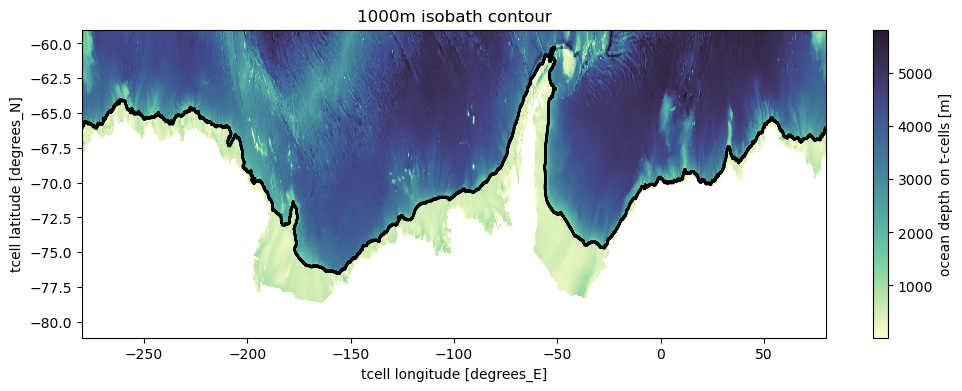

In [31]:
ht = cc.querying.getvar(control, 'ht',master_session, n=1, ncfile = 'ocean_grid.nc')
ht = ht.sel(yt_ocean=lat_range)
yt_ocean = cc.querying.getvar(control, 'yt_ocean',master_session, n=1, ncfile = 'ocean_grid.nc')
xt_ocean = cc.querying.getvar(control, 'xt_ocean',master_session, n=1, ncfile = 'ocean_grid.nc')
yt_ocean = yt_ocean.sel(yt_ocean=lat_range)


fig, axes = plt.subplots(figsize = (12,4))
ht.plot(ax = axes, cmap = cm.cm.deep)
axes.contour(xt_ocean.values, yt_ocean.values,np.abs(mask_x_transport)+np.abs(mask_y_transport),colors = 'k')
axes.set_title('1000m isobath contour')
#plt.savefig('contour.png', dpi = 300)

In [32]:
# now plot age anomaly instead

# select out bottom values:
start_time = '1907-01-01'
end_time = '1909-12-31'
time_slice = slice(start_time,end_time)

age_con = cc.querying.getvar(control, 'age_global',master_session,start_time = start_time,
                            end_time = end_time).sel(time = time_slice,yt_ocean=lat_range)
age_basal = cc.querying.getvar(basal_gade_brine, 'age_global',basal_melt_session,start_time = start_time,
                            end_time = end_time).sel(time = time_slice,yt_ocean=lat_range)
age_basalnobrine = cc.querying.getvar(basal_gade_woa_newname, 'age_global',basal_melt_session,start_time = start_time,
                            end_time = end_time).sel(time = time_slice,yt_ocean=lat_range)

day_in_month = age_basal.time.dt.days_in_month
age_con_mean = (age_con*day_in_month).sum('time')/day_in_month.sum('time')
age_basal_mean = (age_basal*day_in_month).sum('time')/day_in_month.sum('time')
age_basalnobrine_mean = (age_basalnobrine*day_in_month).sum('time')/day_in_month.sum('time')

In [33]:
age_con_mean = age_con_mean.load()
age_basal_mean = age_basal_mean.load()
age_basalnobrine_mean = age_basalnobrine_mean.load()

2024-12-12 10:29:19,691 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2024-12-12 10:29:37,212 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2024-12-12 10:30:55,356 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2024-12-12 10:32:19,774 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


In [34]:
depth_array = age_con.isel(time =0) * 0 + age_con.st_ocean
max_depth = depth_array.max(dim = 'st_ocean', skipna= True)

bottom_age_con = age_con_mean.where(depth_array.st_ocean >= max_depth)
bottom_age_con = bottom_age_con.sum(dim = 'st_ocean')
bottom_age_con = bottom_age_con.load()

bottom_age_basal = age_basal_mean.where(depth_array.st_ocean >= max_depth)
bottom_age_basal = bottom_age_basal.sum(dim = 'st_ocean')
bottom_age_basal = bottom_age_basal.load()

bottom_age_basalnobrine = age_basalnobrine_mean.where(depth_array.st_ocean >= max_depth)
bottom_age_basalnobrine = bottom_age_basalnobrine.sum(dim = 'st_ocean')
bottom_age_basalnobrine = bottom_age_basalnobrine.load()

In [35]:
land_mask = np.squeeze(ht.values)*0
land_mask[np.isnan(land_mask)] = 1
land_mask = np.where(land_mask==1,land_mask,np.nan)
land_mask_masked = np.ma.masked_where((land_mask==0),land_mask)
# make land go all the way to -90S:
land_mask_lat = ht.yt_ocean.values
land_mask_lat[0] = -90



Text(0.5, 1.0, '1000m isobath contour - BasalGadeBrine -- Control')

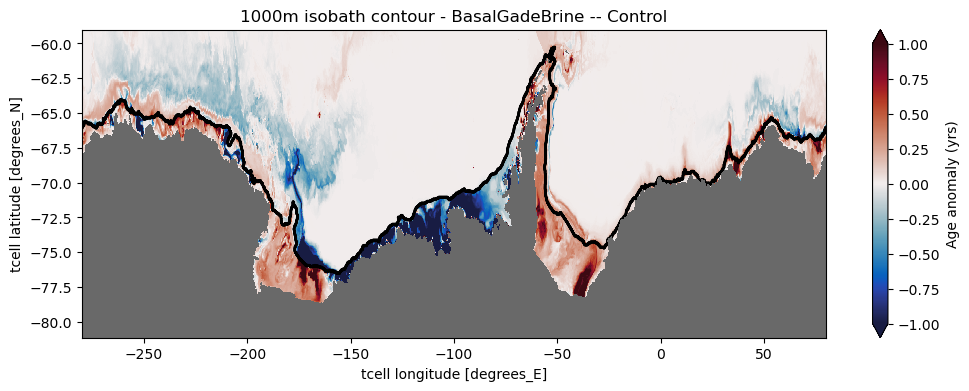

In [36]:
yt_ocean = cc.querying.getvar(control, 'yt_ocean',master_session, n=1, ncfile = 'ocean_grid.nc')
xt_ocean = cc.querying.getvar(control, 'xt_ocean',master_session, n=1, ncfile = 'ocean_grid.nc')
yt_ocean = yt_ocean.sel(yt_ocean=lat_range)


fig, axes = plt.subplots(figsize = (12,4))
(bottom_age_basal-bottom_age_con).plot(ax = axes, cmap = cm.cm.balance, cbar_kwargs = {'label':'Age anomaly (yrs)'}, vmax = 1, vmin = -1)
axes.contour(xt_ocean.values, yt_ocean.values,np.abs(mask_x_transport)+np.abs(mask_y_transport),colors = 'k')
axes.contourf(ht.xt_ocean, land_mask_lat,land_mask_masked,colors='dimgrey',zorder=2,)
axes.set_title('1000m isobath contour - BasalGadeBrine -- Control')


Text(0.5, 1.0, '1000m isobath contour - BasalGade -- Control')

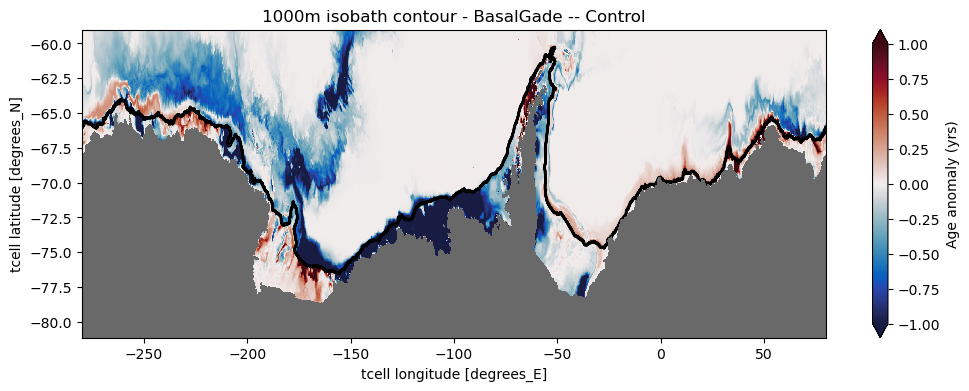

In [37]:
yt_ocean = cc.querying.getvar(control, 'yt_ocean',master_session, n=1, ncfile = 'ocean_grid.nc')
xt_ocean = cc.querying.getvar(control, 'xt_ocean',master_session, n=1, ncfile = 'ocean_grid.nc')
yt_ocean = yt_ocean.sel(yt_ocean=lat_range)


fig, axes = plt.subplots(figsize = (12,4))
(bottom_age_basalnobrine-bottom_age_con).plot(ax = axes, cmap = cm.cm.balance, cbar_kwargs = {'label':'Age anomaly (yrs)'}, vmax = 1, vmin = -1)
axes.contour(xt_ocean.values, yt_ocean.values,np.abs(mask_x_transport)+np.abs(mask_y_transport),colors = 'k')
axes.contourf(ht.xt_ocean, land_mask_lat,land_mask_masked,colors='dimgrey',zorder=2,)
axes.set_title('1000m isobath contour - BasalGade -- Control')


### Make nicer y axis than `contour_index` by loading in lon/lat/distance of contour

according to cosima recipes https://nbviewer.org/github/claireyung/cosima-recipes/blob/master/DocumentedExamples/Cross-contour_transport.ipynb

In [39]:
expt = control
session = master_session

In [40]:
mask_y_transport = data['mask_y_transport']
mask_x_transport = data['mask_x_transport']
mask_y_transport_numbered = data['mask_y_transport_numbered']
mask_x_transport_numbered = data['mask_x_transport_numbered']

yt_ocean = cc.querying.getvar(expt,'yt_ocean',session,n=1)
yt_ocean = yt_ocean.sel(yt_ocean=lat_range)
yu_ocean = cc.querying.getvar(expt,'yu_ocean',session,n=1)
yu_ocean = yu_ocean.sel(yu_ocean=lat_range)
xt_ocean = cc.querying.getvar(expt,'xt_ocean',session,n=1)
xu_ocean = cc.querying.getvar(expt,'xu_ocean',session,n=1)

# Convert contour masks to data arrays, so we can multiply them later.
# We need to ensure the lat lon coordinates correspond to the actual data location:
#       The y masks are used for vhrho, so like vhrho this should have dimensions (yu_ocean, xt_ocean).
#       The x masks are used for uhrho, so like uhrho this should have dimensions (yt_ocean, xu_ocean).
#       However the actual name will always be simply y_ocean/x_ocean irrespective of the variable
#       to make concatenation of transports in both direction and sorting possible.

mask_x_transport = xr.DataArray(mask_x_transport, coords = [yt_ocean, xu_ocean], dims=['y_ocean', 'x_ocean'])
mask_y_transport = xr.DataArray(mask_y_transport, coords = [yu_ocean, xt_ocean], dims=['y_ocean', 'x_ocean'])
mask_x_transport_numbered = xr.DataArray(mask_x_transport_numbered, coords = [yt_ocean, xu_ocean], dims=['y_ocean', 'x_ocean'])
mask_y_transport_numbered = xr.DataArray(mask_y_transport_numbered, coords = [yu_ocean, xt_ocean], dims=['y_ocean', 'x_ocean'])

# ### Stack contour data into 1D

# Create the contour order data-array. Note that in this procedure the x-grid counts have x-grid
#   dimensions and the y-grid counts have y-grid dimensions, but these are implicit, the dimension 
#   *names* are kept general across the counts, the generic y_ocean, x_ocean, so that concatening works
#   but we dont double up with numerous counts for one lat/lon point.

# stack contour data into 1d:
mask_x_numbered_1d = mask_x_transport_numbered.stack(contour_index = ['y_ocean', 'x_ocean'])
mask_x_numbered_1d = mask_x_numbered_1d.where(mask_x_numbered_1d > 0, drop = True)
mask_y_numbered_1d = mask_y_transport_numbered.stack(contour_index = ['y_ocean', 'x_ocean'])
mask_y_numbered_1d = mask_y_numbered_1d.where(mask_y_numbered_1d > 0, drop = True)
contour_ordering = xr.concat((mask_x_numbered_1d,mask_y_numbered_1d), dim = 'contour_index')
contour_ordering = contour_ordering.sortby(contour_ordering)
contour_index_array = np.arange(1,len(contour_ordering)+1)

# get lat and lon along contour, useful for plotting later:
lat_along_contour = contour_ordering.y_ocean
lon_along_contour = contour_ordering.x_ocean
# don't need the multi-index anymore, replace with contour count
lat_along_contour.coords['contour_index'] = contour_index_array
lon_along_contour.coords['contour_index'] = contour_index_array



In [14]:
# ## save distance - this takes time so instead load result in next cell

# dxu = cc.querying.getvar(expt,'dxu',session,ncfile = 'ocean_grid.nc',n=1)
# dxu = dxu.sel(yu_ocean = lat_range)
# dyt = cc.querying.getvar(expt,'dyt',session,ncfile = 'ocean_grid.nc',n=1)
# dyt = dyt.sel(yt_ocean = lat_range)
# num_points = len(lat_along_contour)
# lat_t = cc.querying.getvar(expt,'geolat_t',session,ncfile = 'ocean_grid.nc',n=1)
# lat_t = lat_t.sel(yt_ocean = lat_range)
# lon_t = cc.querying.getvar(expt,'geolon_t',session,ncfile = 'ocean_grid.nc',n=1)
# lon_t = lon_t.sel(yt_ocean = lat_range)

# # if there is a bend in the contour, add the distance using length of diagonal, not sum of
# # 2 edges, to be more representative.    
# distance_along_contour = np.zeros((num_points))
# x_indices = np.sort(mask_x_transport_numbered.values[mask_x_transport_numbered.values>0])
# y_indices = np.sort(mask_y_transport_numbered.values[mask_y_transport_numbered.values>0])
# skip = False
# for count in range(1,num_points):
#     if skip == True:
#         skip = False
#         continue
#     if count in y_indices:
#         if count + 1 in y_indices:
#             # note dxu and dyt do no vary in x:
#             jj = np.where(mask_y_transport_numbered==count)[0]
#             distance_along_contour[count-1] = (dxu[jj,990])[0]
#         else:
#             jj0 = np.where(mask_y_transport_numbered==count)[0]
#             jj1 = np.where(mask_x_transport_numbered==count+1)[0]
#             diagonal_distance = 0.5*np.sqrt((dxu[jj0,990])[0]**2+\
#                 (dyt[jj1,990])[0]**2)
#             distance_along_contour[count-1] = diagonal_distance
#             distance_along_contour[count] = diagonal_distance
#             # skip to next count:
#             skip = True
#     # count in x_indices:
#     else:
#         if count + 1 in x_indices:
#             jj = np.where(mask_x_transport_numbered==count)[0]
#             distance_along_contour[count-1] = (dyt[jj,990])[0]
#         else:
#             jj0 = np.where(mask_x_transport_numbered==count)[0]
#             jj1 = np.where(mask_y_transport_numbered==count+1)[0]
#             diagonal_distance = 0.5*np.sqrt((dyt[jj0,990])[0]**2+\
#                 (dxu[jj1,990])[0]**2)
#             distance_along_contour[count-1] = diagonal_distance
#             distance_along_contour[count] = diagonal_distance
#             # skip to next count:
#             skip = True
# # fix last value:
# if distance_along_contour[-1] == 0:
#     count = count + 1
#     if count in y_indices:
#         jj = np.where(mask_y_transport_numbered==count)[0]
#         distance_along_contour[-1] = (dxu[jj,990])[0]
#     else:
#         jj = np.where(mask_x_transport_numbered==count)[0]
#         distance_along_contour[-1] = (dyt[jj,990])[0]

# # units are 10^3 km:
# distance_along_contour = np.cumsum(distance_along_contour)/1e3/1e3 
# #save_dir = '/g/data/x77/cy8964/Post_Process/access-om2/'
# #ds_latlondist = xr.Dataset({'distance_along_contour': distance_along_contour})
# #ds_latlondist.to_netcdf(save_dir+'1000m_isobath_contour_distance.nc')

In [15]:
distance_along_contour = xr.open_dataset('/g/data/x77/cy8964/Post_Process/access-om2/1000m_isobath_contour_distance.nc').distance_along_contour

In [16]:
#determine where to put lon tick marks
distance_indices = np.zeros(8)
for i in np.arange(100,len(lon_along_contour.values)):
    if (distance_indices[1]==0):
        if (lon_along_contour.values[i]>-240):
            distance_indices[1] = lon_along_contour.contour_index.values[i]
    if (distance_indices[2]==0):
        if (lon_along_contour.values[i]>-180):
            distance_indices[2] = lon_along_contour.contour_index.values[i]
    if (distance_indices[3]==0):
        if (lon_along_contour.values[i]>-120):
            distance_indices[3] = lon_along_contour.contour_index.values[i]
    if (distance_indices[4]==0):
        if lon_along_contour.values[i]>-60:
            distance_indices[4] = lon_along_contour.contour_index.values[i]
    if (distance_indices[5]==0):
        if (lon_along_contour.values[i]>0):
            distance_indices[5] = lon_along_contour.contour_index.values[i]
    if (distance_indices[6]==0):
        if (lon_along_contour.values[i]>60):
            distance_indices[6] = lon_along_contour.contour_index.values[i]
distance_indices[7] = len(lon_along_contour.contour_index.values)-1


## Save transport individual files together (time mean)

This section saves data as netcdfs to improve loading speed.

(SKIP THIS SECTION IF ALREADY COMPLETE)

In [18]:
#get time data
temp = cc.querying.getvar(control,'temp',master_session)
temp = temp.sel(time = slice('1900-01-01','1909-12-31'))
time_data = temp.time

In [19]:
def load_monthly_data (name):
    ## load monthly saved transports as a time series

    test = xr.open_mfdataset('/g/data/x77/cy8964/Post_Process/access-om2/'+name+
                             '/Antarctic_cross_slope/vol_trans_across_contour_1900_01.nc').vol_trans_across_contour_binned
    vol_trans_across_contour_t = xr.zeros_like(test)
    vol_trans_across_contour_t  = vol_trans_across_contour_t.expand_dims({"time":time_data})
    count_days = 0
    # load 10 year (10 years x 12 months)
    for j in np.arange(1900,1910):
        for i in np.arange(1,13):
            it = xr.open_mfdataset('/g/data/x77/cy8964/Post_Process/access-om2/'+name+'/Antarctic_cross_slope/vol_trans_across_contour_'+str(j)+'_'+str(i).zfill(2)+'.nc')
            it.load()
            vol_trans_across_contour_t[i+12*(j-1900)-1,:,:] = it.vol_trans_across_contour_binned 
            count_days = count_days + it.ndays.values
        print(j)
    return vol_trans_across_contour_t, count_days

In [39]:
basal_vol_trans, ndays = load_monthly_data(basal_gade_woa)
print(ndays)
control_vol_trans, ndays = load_monthly_data(control)
print(ndays)
basal_nogade_vol_trans, ndays = load_monthly_data(basal_nogade_woa)
print(ndays)
basal_gade_brine_vol_trans, ndays = load_monthly_data(basal_gade_brine)
print(ndays)

1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
3650
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
3650
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
3650
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
3650


In [40]:
#10 year time average
def av_10yr (array):
    array_10yr = (array*array.time.dt.days_in_month).sum('time') * \
                        1/(array.time.dt.days_in_month).sum('time')
    return array_10yr
def av_last_5yr (array):
    array = array.sel(time = slice('1905-01-01','1909-12-31'))
    array_last_5yr = (array*array.time.dt.days_in_month).sum('time') * \
                        1/(array.time.dt.days_in_month).sum('time')
    return array_last_5yr
def av_last_3yr (array):
    array = array.sel(time = slice('1907-01-01','1909-12-31'))
    array_last_5yr = (array*array.time.dt.days_in_month).sum('time') * \
                        1/(array.time.dt.days_in_month).sum('time')
    return array_last_5yr
def yrly (array):
    array_yrly = (array*array.time.dt.days_in_month).groupby('time.year').sum('time') * \
                        1/(array.time.dt.days_in_month).groupby('time.year').sum('time')
    return array_yrly


In [41]:
save_dir = '/g/data/x77/cy8964/basal_mom5-collaborative-project/notebooks/cross_contour/'
for i in np.arange(4):
    transport_arr = [basal_vol_trans, control_vol_trans,
                     basal_nogade_vol_trans,basal_gade_brine_vol_trans][i]
    name = ['basal','control','basal_nogade','basal_gade_brine'][i]
    average_transport = av_last_3yr(transport_arr)
    average_transport.load()
    ds = xr.Dataset({'vol_trans_across_contour_binned_last_3yr': average_transport})
    ds.to_netcdf(save_dir+name+'_vol_trans_across_contour_binned_last_3yr.nc')

### Transport cumulative sums for different density classes and sectors

Define in longitude space what the cut-off values for regions should be.


In [17]:
AdelieW = -280
AdelieE = -200
RossW = -200
RossE = -150
# WAW = -150
# WAE = -65
AmW = -150
AmE = -100
BeW = -100
BeE = -65

WeddellW = -65
WeddellE = 0
PrydzW = 0
PrydzE = 80

#### need to find corresponding contour indices for sectors

In [18]:
basin_indices = np.zeros(7)
for i in np.arange(100,len(lon_along_contour.values)):
    if (basin_indices[1]==0):
        if (lon_along_contour.values[i]>AdelieE):
            basin_indices[1] = lon_along_contour.contour_index.values[i]
    if (basin_indices[2]==0):
        if (lon_along_contour.values[i]>RossE):
            basin_indices[2] = lon_along_contour.contour_index.values[i]
    if (basin_indices[3]==0):
        if (lon_along_contour.values[i]>AmE):
            basin_indices[3] = lon_along_contour.contour_index.values[i]
    if (basin_indices[4]==0):
        if (lon_along_contour.values[i]>BeE):
            basin_indices[4] = lon_along_contour.contour_index.values[i]
    if (basin_indices[5]==0):
        if lon_along_contour.values[i]>WeddellE:
            basin_indices[5] = lon_along_contour.contour_index.values[i]
    if (basin_indices[6]==0):
        if (lon_along_contour.values[i]>PrydzE):
            basin_indices[6] = lon_along_contour.contour_index.values[i]
basin_indices

array([   0., 1270., 2149., 2803., 3338., 4798.,    0.])

In [19]:
Adelie = slice(basin_indices[0],basin_indices[1])
Ross = slice(basin_indices[1],basin_indices[2])
Am = slice(basin_indices[2],basin_indices[3])
Be = slice(basin_indices[3],basin_indices[4])
Weddell = slice(basin_indices[4], basin_indices[5])
Prydz = slice(basin_indices[5],6002)

# Now plot

In [20]:

# CONTROL
session_name = '/g/data/v45/wf4500/databases/gdata_01deg_jra55v13_ryf9091_DSW.db'
master_session = cc.database.create_session(session_name)
#experiment
control = '01deg_jra55v13_ryf9091_DSW'

#PERTURBATIONS
session_name = '/g/data/ik11/databases/basal_melt_MOM5.db'
basal_melt_session = cc.database.create_session(session_name)
#experiments
basal_gade_woa_newname = '01deg_jra55v13_ryf9091_DSW_BasalGade_NoIcb'
basal_nogade_woa = '01deg_jra55v13_ryf9091_DSW_BasalNoGade_NoIcb'
basal_gade_brine = '01deg_jra55v13_ryf9091_DSW_BasalGade_NoIcb_Brine'

#dict with plotting colors, linestyles, linewidth, and a shortname which may or may not be useful
exptdict = OrderedDict([
    ('Control',  {'expt':control,'session':master_session,
                  'colors':"#000000",'linestyles':'-','linewidth':3,'shortname':'control'}),
    ('Basal',  {'expt':basal_nogade_woa,'session':basal_melt_session,
                'colors':"#DDAA33",'linestyles':'--','linewidth':2,'shortname':'basal_nogade'}),
    ('Basal_LH',  {'expt':basal_gade_woa_newname,'session':basal_melt_session,
                    'colors':"#BB5566",'linestyles':'--','linewidth':2,'shortname':'basal'}),
    ('Basal_LH_Brine',  {'expt':basal_gade_brine,'session':basal_melt_session,
                         'colors':"steelblue",'linestyles':'-','linewidth':2,'shortname':'basal_gade_brine'}),
])
keys = ['Control','Basal','Basal_LH','Basal_LH_Brine']

#observational data should be color = 'grey', linestyle = '-', linewidth =3

# to plot:
for i in np.arange(4):
    ekey = keys[i]
    color = exptdict[ekey]['colors']
    #etc....

(b) Circumpolar 1027.7099999999998
(b) Circumpolar 1027.6999999999998
(b) Circumpolar 1027.7199999999998
(b) Circumpolar 1027.7199999999998
(c) Adelie 1027.6699999999998
(c) Adelie 1027.6499999999999
(c) Adelie 1027.6899999999998
(c) Adelie 1027.6799999999998
(d) Ross 1027.8099999999997
(d) Ross 1027.7999999999997
(d) Ross 1027.8199999999997
(d) Ross 1027.8099999999997
(e) Amundsen 1027.56
(e) Amundsen 1027.8199999999997
(e) Amundsen 1027.7899999999997
(e) Amundsen 1027.53
(f) Bellings-
 hausen 1027.7999999999997
(f) Bellings-
 hausen 1027.7999999999997
(f) Bellings-
 hausen 1027.7999999999997
(f) Bellings-
 hausen 1027.7999999999997
(g) Weddell 1027.7099999999998
(g) Weddell 1027.7099999999998
(g) Weddell 1027.7199999999998
(g) Weddell 1027.7099999999998
(h) Prydz 1027.5
(h) Prydz 1027.6499999999999
(h) Prydz 1027.51
(h) Prydz 1027.399999999997


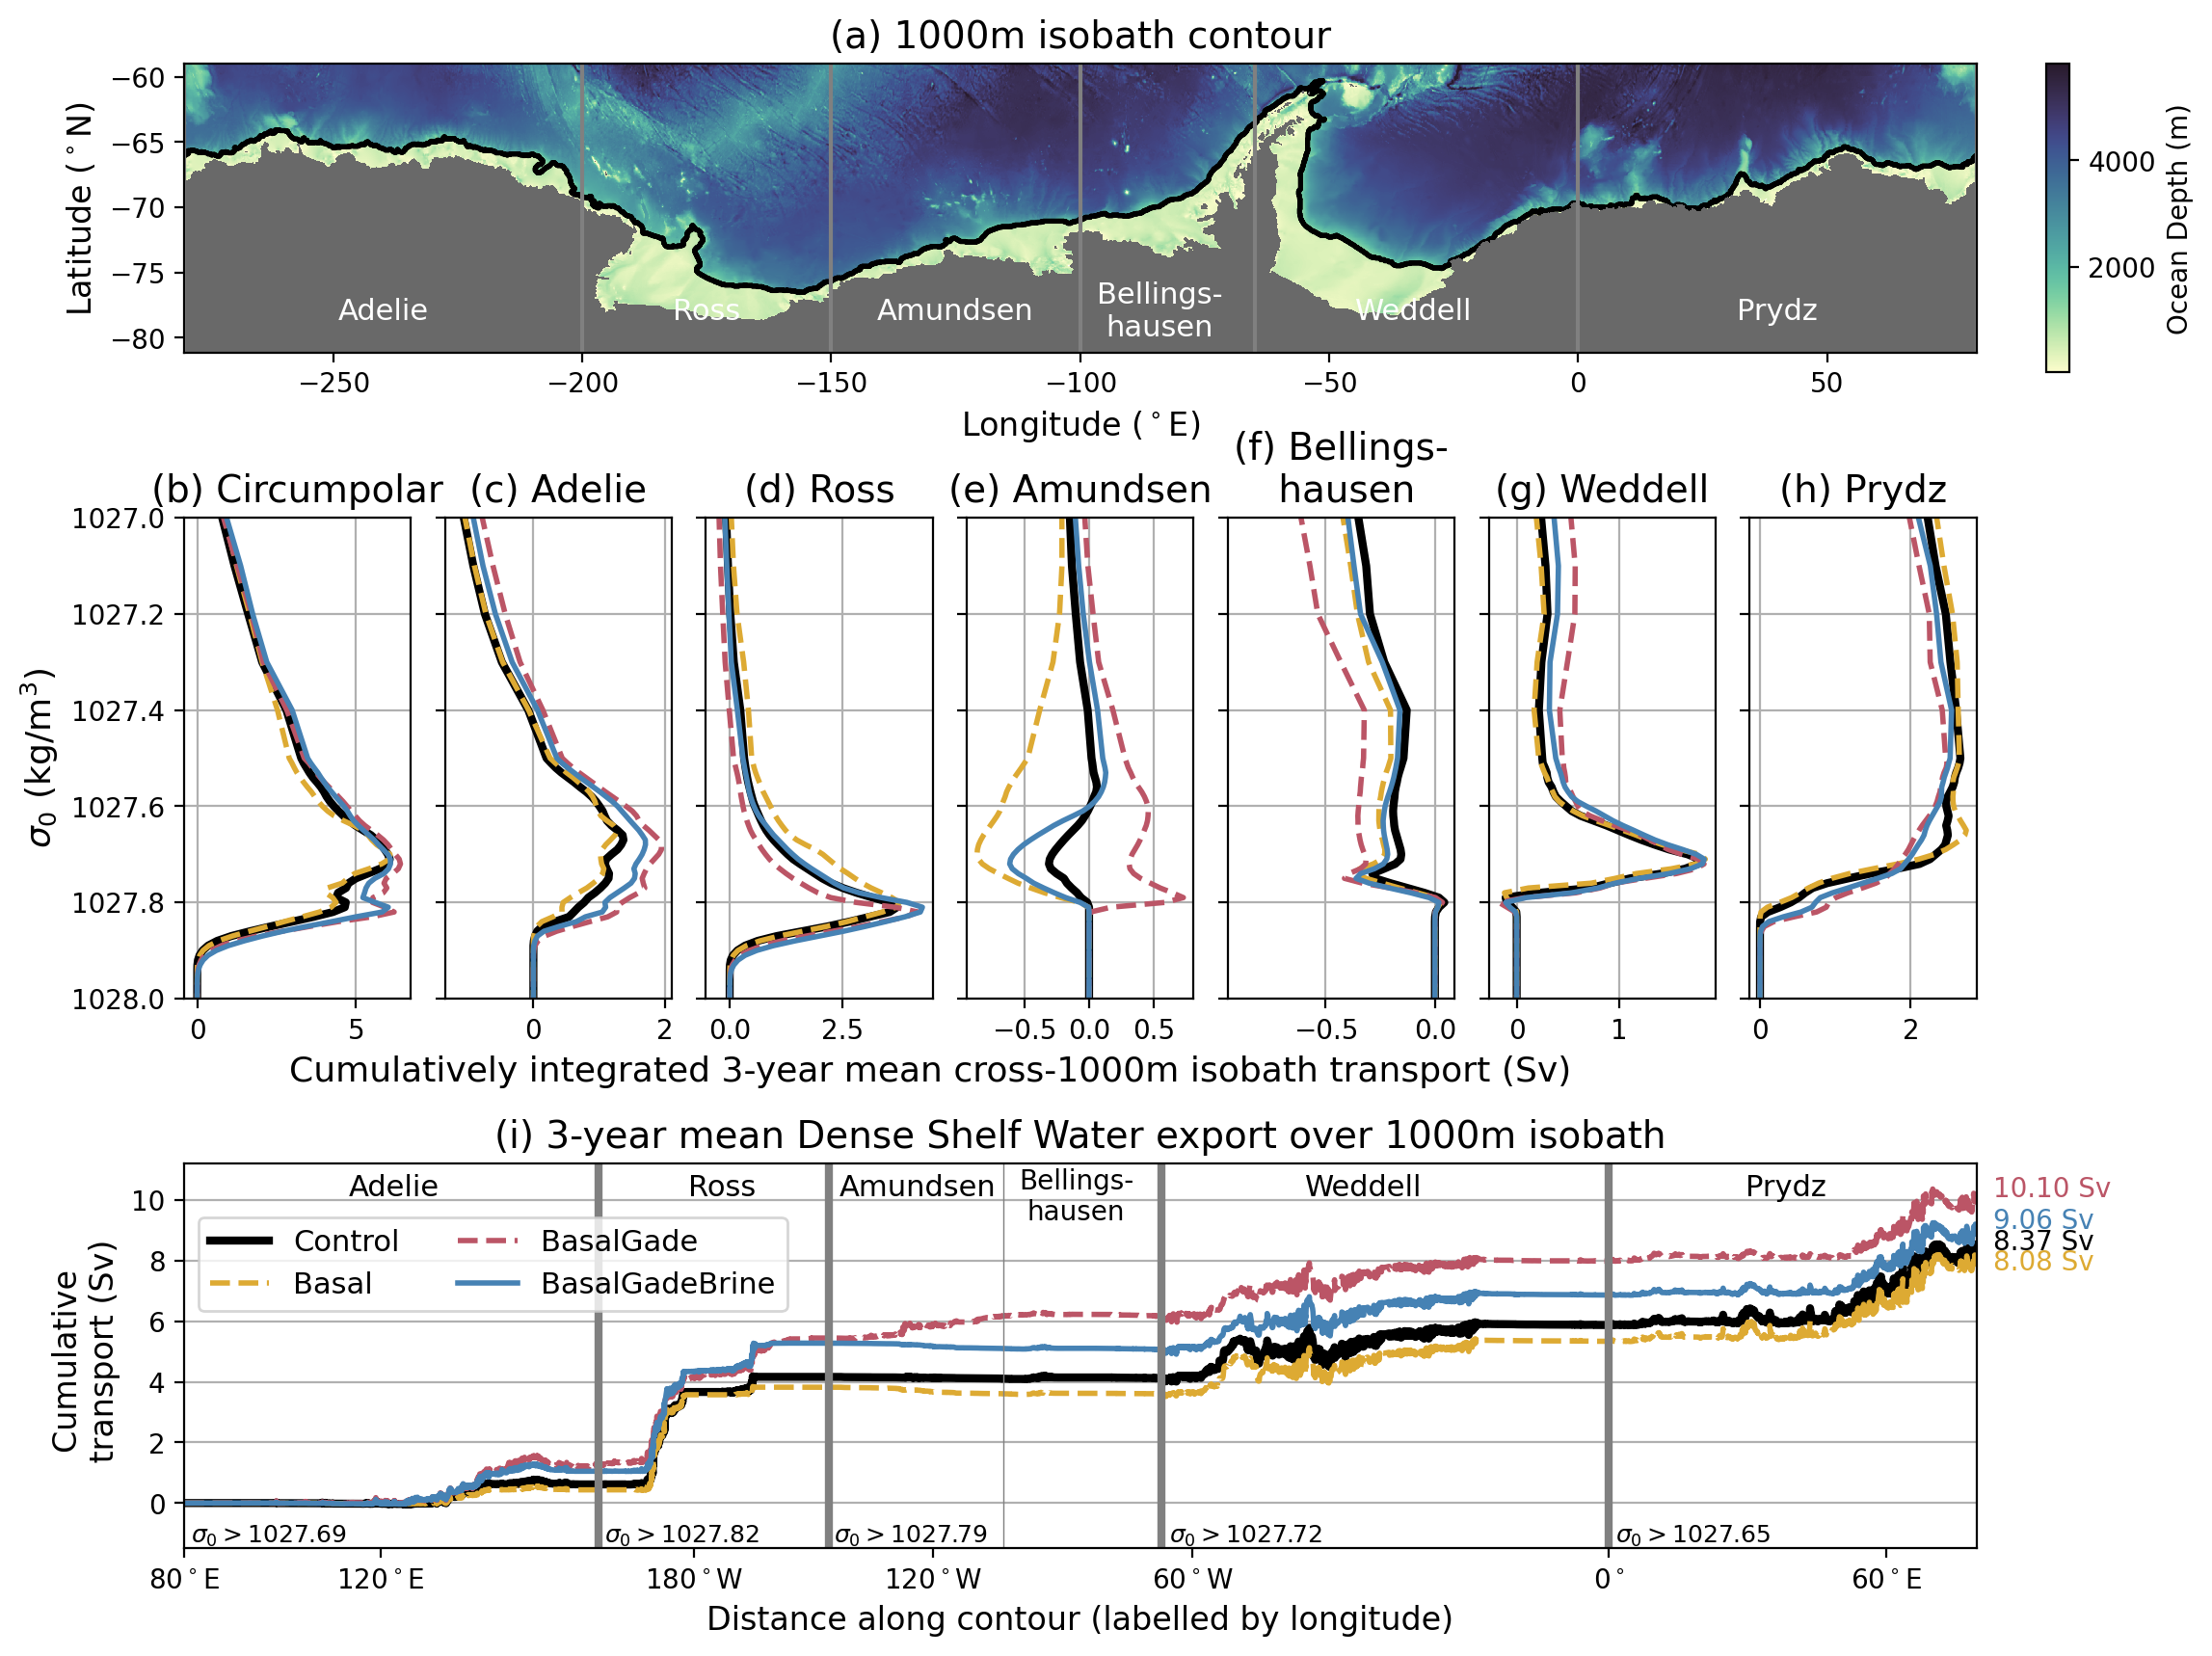

In [21]:
gs = gridspec.GridSpec(3,7, height_ratios = [0.6,1,0.8]) 
fig = plt.figure(figsize = (12,10),dpi = 200)
ax0, ax1, ax2, ax3, ax4, ax4b,ax5,ax6,ax7 = plt.subplot(gs[0,:]), plt.subplot(gs[1,0]), plt.subplot(gs[1,1]), plt.subplot(gs[1,2]),plt.subplot(gs[1,3]),plt.subplot(gs[1,4]),plt.subplot(gs[1,5]),plt.subplot(gs[1,6]),plt.subplot(gs[2,:])

ht = cc.querying.getvar(control, 'ht',master_session, n=1, ncfile = 'ocean_grid.nc')
ht = ht.sel(yt_ocean=lat_range)
yt_ocean = cc.querying.getvar(control, 'yt_ocean',master_session, n=1, ncfile = 'ocean_grid.nc')
xt_ocean = cc.querying.getvar(control, 'xt_ocean',master_session, n=1, ncfile = 'ocean_grid.nc')
yt_ocean = yt_ocean.sel(yt_ocean=lat_range)


h_plot = ht.plot(ax = ax0, cmap = cm.cm.deep, add_colorbar = False)
cax = plt.axes([0.93,0.72,0.01,0.16])
plt.colorbar(h_plot, cax = cax, label = 'Ocean Depth (m)')
ax0.contour(xt_ocean.values, yt_ocean.values,np.abs(mask_x_transport.values)+np.abs(mask_y_transport.values),colors = 'k')
ax0.contourf(ht.xt_ocean, land_mask_lat,land_mask_masked,colors='dimgrey',zorder=2,)

ax0.vlines([-280,-200,-150,-100,-65,0,80],-82,-58,  color = 'grey')
ax0.text(-240, -78, 'Adelie', horizontalalignment='center',verticalalignment='center',fontsize = 11,color = 'w')
ax0.text(-175, -78, 'Ross', horizontalalignment='center',verticalalignment='center',fontsize = 11,color = 'w')
ax0.text(-125, -78, 'Amundsen', horizontalalignment='center',verticalalignment='center',fontsize = 11,color = 'w')
ax0.text(-84, -78, 'Bellings-\nhausen', horizontalalignment='center',verticalalignment='center',fontsize = 11,color = 'w')
ax0.text(-33, -78, 'Weddell', horizontalalignment='center',verticalalignment='center',fontsize = 11,color = 'w')
ax0.text(40, -78, 'Prydz', horizontalalignment='center',verticalalignment='center',fontsize = 11,color = 'w')

ax0.set_title('(a) 1000m isobath contour', fontsize = 14)
ax0.set_ylabel('Latitude ($^\circ$N)', fontsize = 12)
ax0.set_xlabel('Longitude ($^\circ$E)', fontsize = 12)

save_dir = '/g/data/x77/cy8964/basal_mom5-collaborative-project/notebooks/cross_contour/'

for n in np.arange(7):
    #print(n)
    ax = [ax1,ax2,ax3,ax4,ax4b,ax5,ax6][n]
    sector = [slice(0,6002),Adelie, Ross, Am,Be, Weddell, Prydz][n]
    sector_name = ['(b) Circumpolar','(c) Adelie', '(d) Ross', '(e) Amundsen','(f) Bellings-\n hausen', '(g) Weddell', '(h) Prydz'][n]
    for i in np.arange(4):
        ekey = keys[i]
        label = exptdict[ekey]['shortname']
        Nice_label = ekey
        # OPEN FROM SAVED ARRAY
        array = xr.open_dataset(save_dir+label+'_vol_trans_across_contour_binned_last_3yr.nc').vol_trans_across_contour_binned_last_3yr
        color = exptdict[ekey]['colors']
        linestyle = exptdict[ekey]['linestyles']
        linewidth = exptdict[ekey]['linewidth']
        b = (array/1e6).sel(contour_index = sector).sum('contour_index')
        (b.sum('isopycnal_bins') -b.cumsum('isopycnal_bins')).plot(ax = ax, y = 'isopycnal_bins', label = Nice_label,color = color, linestyle = linestyle, linewidth = linewidth)
        print(sector_name, (b.sum('isopycnal_bins') -b.cumsum('isopycnal_bins')).idxmax('isopycnal_bins').values)
    ax.set_ylim(1028.0,1027)
    ax.set_title(sector_name, fontsize = 14)
    ax.grid()
    if n == 0:
        ax.set_ylabel('$\sigma_0$ (kg/m$^3$)', fontsize = 13)
    else:
        ax.set_ylabel('')
        ax.set_yticklabels('')
    if n ==2:
        ax.set_xlabel('                    Cumulatively integrated 3-year mean cross-1000m isobath transport (Sv)', fontsize = 13)  
    else:
        ax.set_xlabel('')


density_sliceAde = slice(1027.69,1030)
density_sliceRos = slice(1027.82,1030)
density_sliceAmBe = slice(1027.79,1030)
density_sliceWe = slice(1027.72,1030)
density_slicePr = slice(1027.65,1030)

for i in np.arange(4):
    ekey = keys[i]
    label = exptdict[ekey]['shortname']
    Nice_label = ekey 
    # OPEN FROM SAVED ARRAY
    array = xr.open_dataset(save_dir+label+'_vol_trans_across_contour_binned_last_3yr.nc').vol_trans_across_contour_binned_last_3yr
    color = exptdict[ekey]['colors']
    linestyle = exptdict[ekey]['linestyles']
    offset = [0,-0.4,0,0][i]
    linewidth = exptdict[ekey]['linewidth']
    #copy array so we can fill it with values from the different density bins for different Antarctic sectors
    array_copy = xr.zeros_like(array.isel(isopycnal_bins = 0))
    for j in np.arange(len(array_copy)):
        if j <= 1270: #border of Adelie and Ross
            array_copy[j] = (10**(-6)*array.sel(isopycnal_bins = density_sliceAde)).sum('isopycnal_bins').values[j]            
        if j <= 2149: #border between Ross and Amundsen
            array_copy[j] = (10**(-6)*array.sel(isopycnal_bins = density_sliceRos)).sum('isopycnal_bins').values[j]
        elif j <= 3338: #border between Bellingshausen and Weddell
            array_copy[j] = (10**(-6)*array.sel(isopycnal_bins = density_sliceAmBe)).sum('isopycnal_bins').values[j]
        elif j <=4798: #border between weddell and prydz
            array_copy[j] = (10**(-6)*array.sel(isopycnal_bins = density_sliceWe)).sum('isopycnal_bins').values[j]
        else:
            array_copy[j] = (10**(-6)*array.sel(isopycnal_bins = density_slicePr)).sum('isopycnal_bins').values[j]
    
    ax7.plot(distance_along_contour,array_copy.cumsum('contour_index'),label = Nice_label, color = color, linestyle = linestyle, linewidth = linewidth)
    ax7.text(distance_along_contour[-1]+0.2,offset + array_copy.cumsum('contour_index')[-1],
             "{:.2f}".format(array_copy.cumsum('contour_index')[-1].values) + ' Sv', color = color)
ax7.set_ylabel('Cumulative \n transport (Sv)', fontsize = 12)
ax7.set_xticks(distance_along_contour[distance_indices.astype(int)[:-1]])
ax7.set_xticklabels(('80$^\circ$E','120$^\circ$E','180$^\circ$W','120$^\circ$W','60$^\circ$W','0$^\circ$','60$^\circ$E'));
ax7.set_xlim(0,distance_along_contour[-1]);
ax7.set_xlabel('Distance along contour (labelled by longitude)', fontsize = 12)

inds= [1270, 2149,  3338, 4798]
ax7.vlines(distance_along_contour[inds],-2,11.2,  color = 'grey',linewidth = 3)
inds= [2803]
ax7.vlines(distance_along_contour[inds],-2,11.2,  color = 'grey',linewidth = 0.5)


# region labels
ax7.text(distance_along_contour[635], 10.4, 'Adelie', horizontalalignment='center',verticalalignment='center',fontsize = 11)
ax7.text(distance_along_contour[1709], 10.4, 'Ross', horizontalalignment='center',verticalalignment='center',fontsize = 11)
ax7.text(distance_along_contour[2500], 10.4, 'Amundsen', horizontalalignment='center',verticalalignment='center',fontsize = 11)
ax7.text(distance_along_contour[3050], 10.1, 'Bellings-\nhausen', horizontalalignment='center',verticalalignment='center',fontsize = 10)
ax7.text(distance_along_contour[3900], 10.4, 'Weddell', horizontalalignment='center',verticalalignment='center',fontsize = 11)
ax7.text(distance_along_contour[5399], 10.4, 'Prydz', horizontalalignment='center',verticalalignment='center',fontsize = 11)

#density bin labels
ax7.text(distance_along_contour[20], -1.1, '$\sigma_0>1027.69$', horizontalalignment='left',verticalalignment='center',fontsize = 9)
ax7.text(distance_along_contour[1290], -1.1, '$\sigma_0>1027.82$', horizontalalignment='left',verticalalignment='center',fontsize = 9)
ax7.text(distance_along_contour[2170], -1.1, '$\sigma_0>1027.79$', horizontalalignment='left',verticalalignment='center',fontsize = 9)
ax7.text(distance_along_contour[3360], -1.1, '$\sigma_0>1027.72$', horizontalalignment='left',verticalalignment='center',fontsize = 9)
ax7.text(distance_along_contour[4820], -1.1, '$\sigma_0>1027.65$', horizontalalignment='left',verticalalignment='center',fontsize = 9)


ax7.set_ylim(-1.5,11.2)
ax7.grid(axis = 'y')
ax7.legend(loc = 'upper left',fontsize = 11, ncol=2, bbox_to_anchor = (0,0.9))
ax7.set_title('(i) 3-year mean Dense Shelf Water export over 1000m isobath',fontsize = 14)

fig.subplots_adjust(hspace = 0.43, wspace = 0.15)

# Plot with age anomaly instead

(b) Circumpolar 1027.7099999999998
(b) Circumpolar 1027.6999999999998
(b) Circumpolar 1027.7199999999998
(b) Circumpolar 1027.7199999999998
(c) Adelie 1027.6699999999998
(c) Adelie 1027.6499999999999
(c) Adelie 1027.6899999999998
(c) Adelie 1027.6799999999998
(d) Ross 1027.8099999999997
(d) Ross 1027.7999999999997
(d) Ross 1027.8199999999997
(d) Ross 1027.8099999999997
(e) Amundsen 1027.56
(e) Amundsen 1027.8199999999997
(e) Amundsen 1027.7899999999997
(e) Amundsen 1027.53
(f) Bellings-
 hausen 1027.7999999999997
(f) Bellings-
 hausen 1027.7999999999997
(f) Bellings-
 hausen 1027.7999999999997
(f) Bellings-
 hausen 1027.7999999999997
(g) Weddell 1027.7099999999998
(g) Weddell 1027.7099999999998
(g) Weddell 1027.7199999999998
(g) Weddell 1027.7099999999998
(h) Prydz 1027.5
(h) Prydz 1027.6499999999999
(h) Prydz 1027.51
(h) Prydz 1027.399999999997


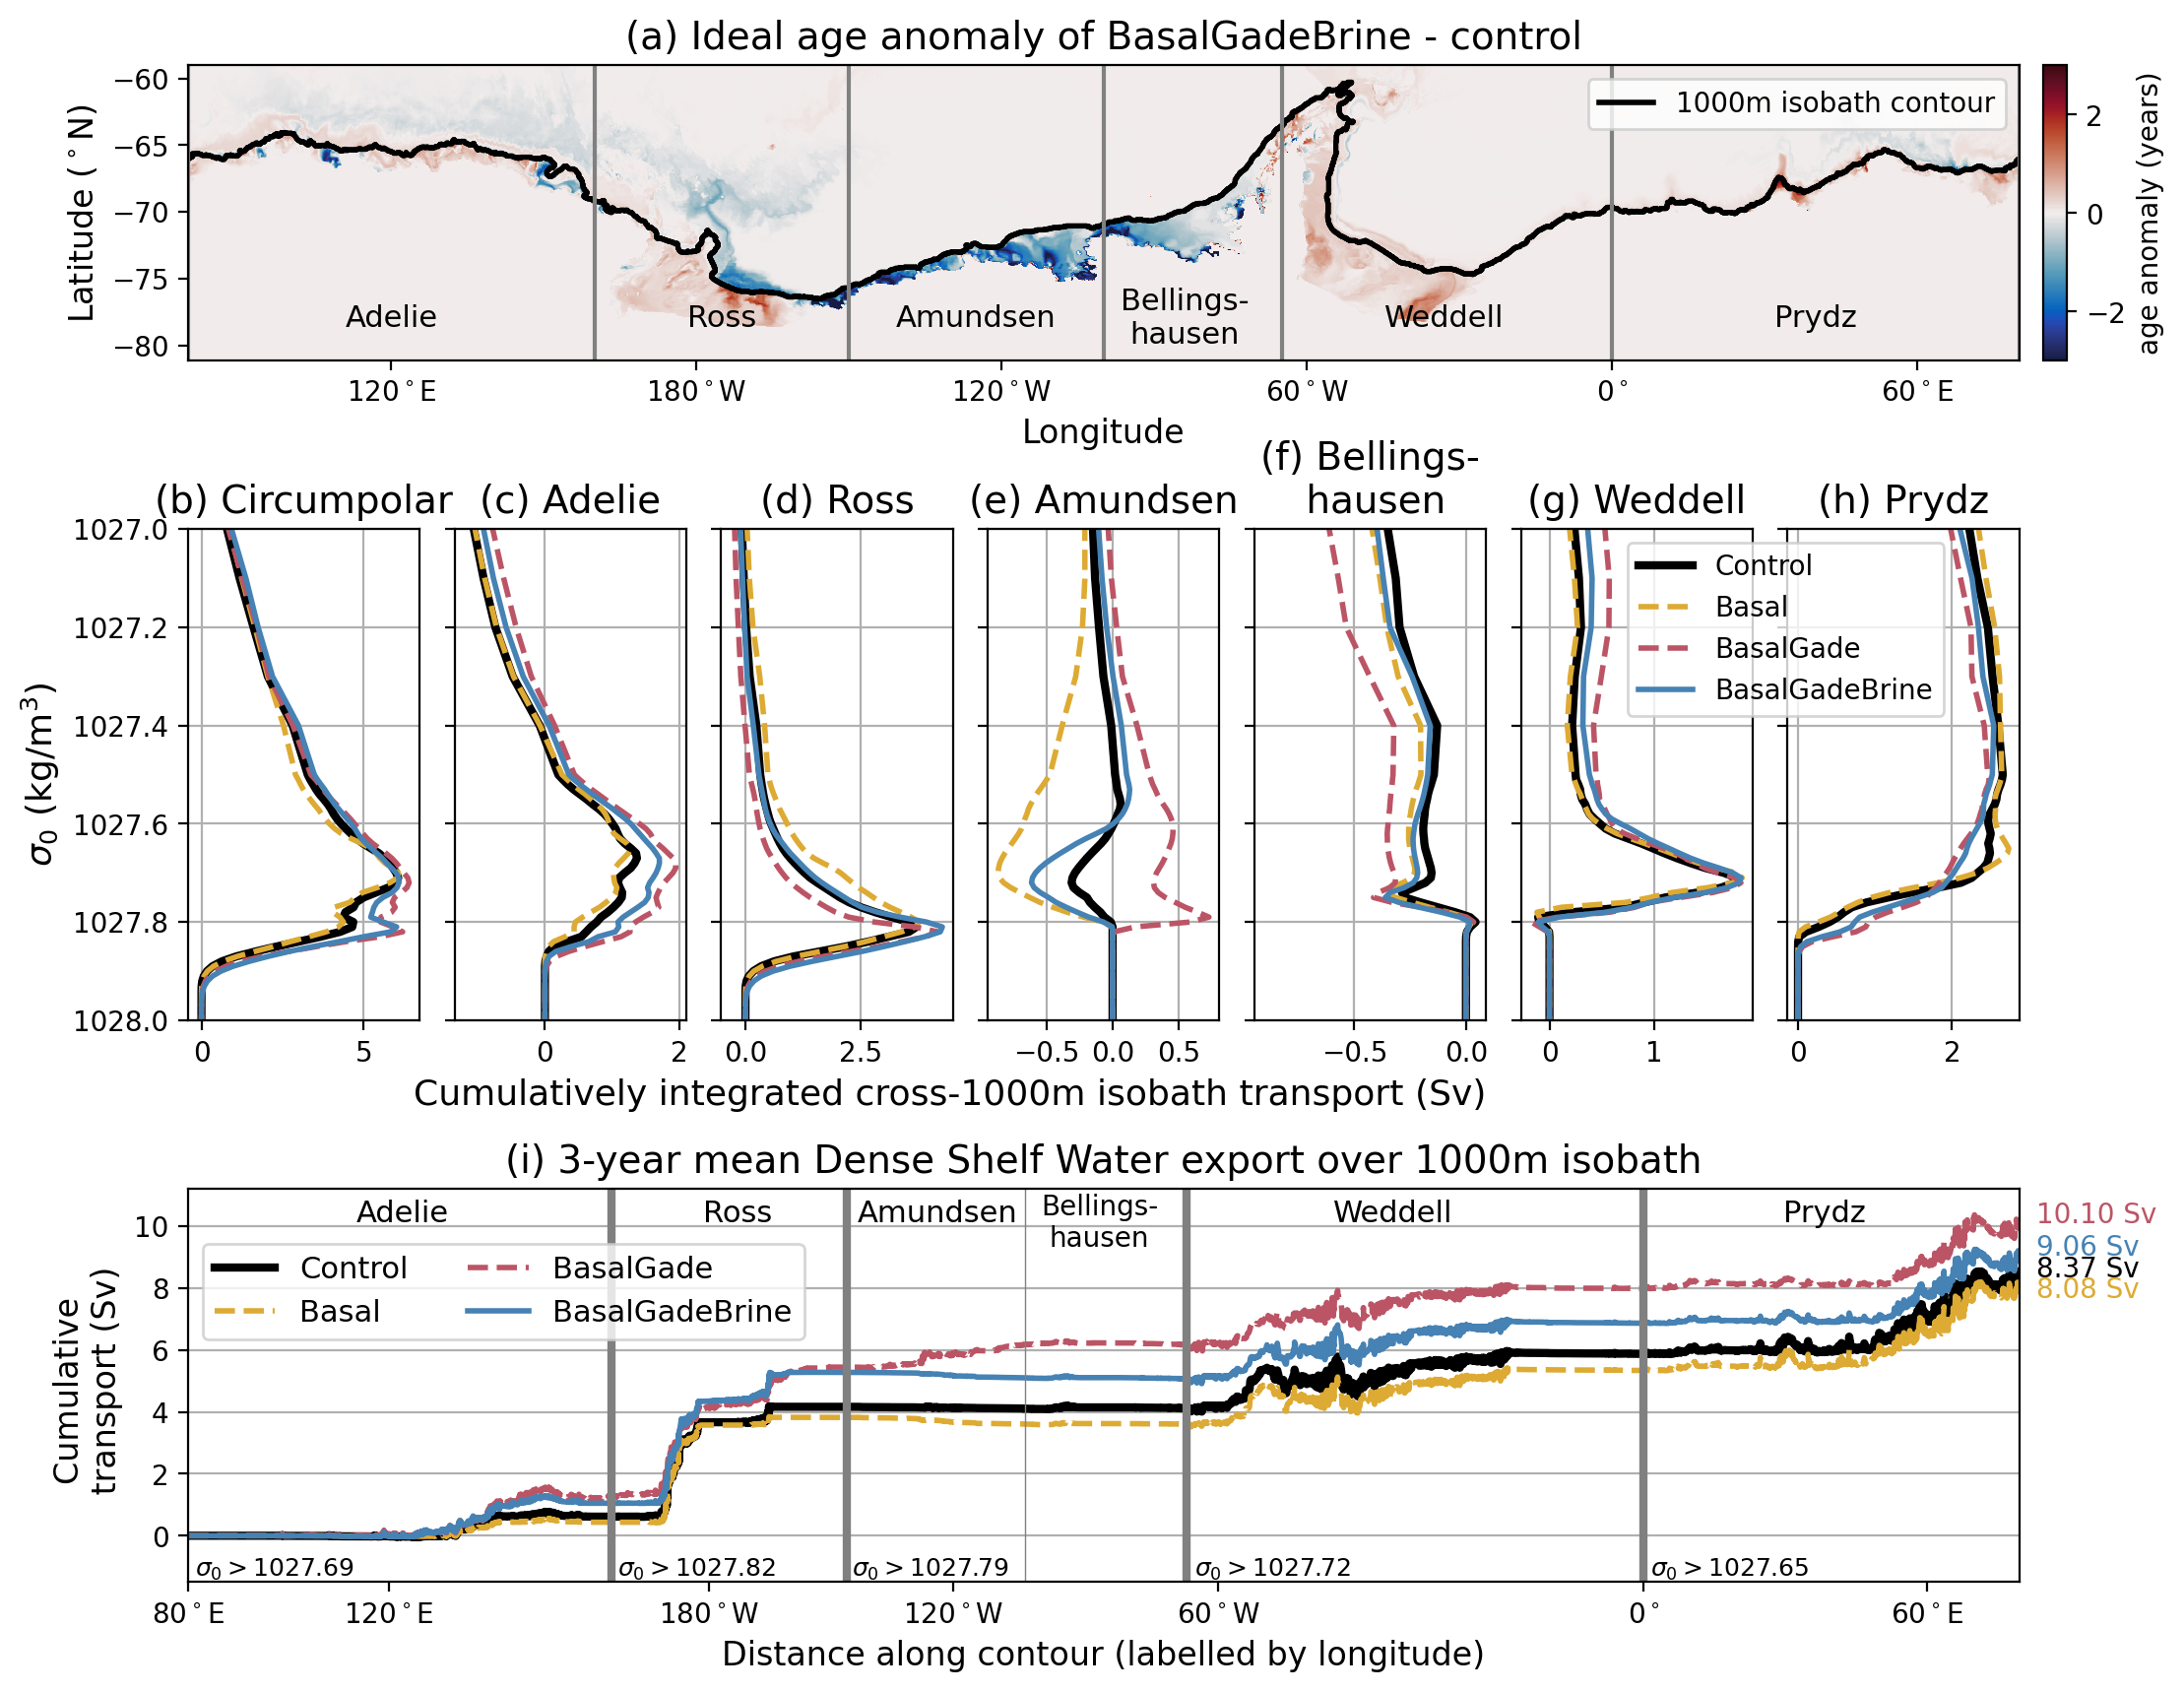

In [40]:
gs = gridspec.GridSpec(3,7, height_ratios = [0.6,1,0.8]) 
fig = plt.figure(figsize = (12,10),dpi = 200)
ax0, ax1, ax2, ax3, ax4, ax4b,ax5,ax6,ax7 = plt.subplot(gs[0,:]), plt.subplot(gs[1,0]), plt.subplot(gs[1,1]), plt.subplot(gs[1,2]),plt.subplot(gs[1,3]),plt.subplot(gs[1,4]),plt.subplot(gs[1,5]),plt.subplot(gs[1,6]),plt.subplot(gs[2,:])

yt_ocean = cc.querying.getvar(control, 'yt_ocean',master_session, n=1, ncfile = 'ocean_grid.nc')
xt_ocean = cc.querying.getvar(control, 'xt_ocean',master_session, n=1, ncfile = 'ocean_grid.nc')
yt_ocean = yt_ocean.sel(yt_ocean=lat_range)

age_plot = (bottom_age_basal-bottom_age_con).plot(ax = ax0, cmap = cm.cm.balance, vmax = 3, vmin = -3,add_colorbar = False)
cax = plt.axes([0.91,0.73,0.01,0.15])
plt.colorbar(age_plot, cax = cax, label = 'age anomaly (years)')
ax0.contour(xt_ocean.values, yt_ocean.values,np.abs(mask_x_transport.values)+np.abs(mask_y_transport.values),colors = 'k')

ax0.vlines([-280,-200,-150,-100,-65,0,80],-82,-58,  color = 'grey')
ax0.text(-240, -80, 'Adelie', horizontalalignment='center',verticalalignment='center',fontsize = 11)
ax0.text(-175, -80, 'Ross', horizontalalignment='center',verticalalignment='center',fontsize = 11)
ax0.text(-125, -80, 'Amundsen', horizontalalignment='center',verticalalignment='center',fontsize = 11)
ax0.text(-84, -80, 'Bellings-\nhausen', horizontalalignment='center',verticalalignment='center',fontsize = 11)
ax0.text(-33, -80, 'Weddell', horizontalalignment='center',verticalalignment='center',fontsize = 11)
ax0.text(40, -80, 'Prydz', horizontalalignment='center',verticalalignment='center',fontsize = 11)

# make a fake object for legend, out of the domain
ax0.plot([0,1],[0,1],color = 'k', linewidth = 2,label = '1000m isobath contour')

ax0.set_title('(a) Ideal age anomaly of BasalGadeBrine - control', fontsize = 14)
ax0.set_ylabel('Latitude ($^\circ$N)', fontsize = 12)
ax0.set_xlabel('Longitude', fontsize = 12)
ax0.set_xticks(np.array([-240,-180,-120,-60,0,60]))
ax0.set_xticklabels(('120$^\circ$E','180$^\circ$W','120$^\circ$W','60$^\circ$W','0$^\circ$','60$^\circ$E'))
ax0.legend(loc = 'upper right')
ax0.set_ylim(min(yt_ocean.values),max(yt_ocean.values))

save_dir = '/g/data/x77/cy8964/basal_mom5-collaborative-project/notebooks/cross_contour/'

for n in np.arange(7):
    #print(n)
    ax = [ax1,ax2,ax3,ax4,ax4b,ax5,ax6][n]
    sector = [slice(0,6002),Adelie, Ross, Am,Be, Weddell, Prydz][n]
    sector_name = ['(b) Circumpolar','(c) Adelie', '(d) Ross', '(e) Amundsen','(f) Bellings-\n hausen', '(g) Weddell', '(h) Prydz'][n]
    for i in np.arange(4):
        ekey = keys[i]
        label = exptdict[ekey]['shortname']
        Nice_label = ekey
        # OPEN FROM SAVED ARRAY
        array = xr.open_dataset(save_dir+label+'_vol_trans_across_contour_binned_last_3yr.nc').vol_trans_across_contour_binned_last_3yr
        color = exptdict[ekey]['colors']
        linestyle = exptdict[ekey]['linestyles']
        linewidth = exptdict[ekey]['linewidth']
        b = (array/1e6).sel(contour_index = sector).sum('contour_index')
        (b.sum('isopycnal_bins') -b.cumsum('isopycnal_bins')).plot(ax = ax, y = 'isopycnal_bins', label = Nice_label,color = color, linestyle = linestyle, linewidth = linewidth)
        print(sector_name, (b.sum('isopycnal_bins') -b.cumsum('isopycnal_bins')).idxmax('isopycnal_bins').values)
    ax.set_ylim(1028.0,1027)
    ax.set_title(sector_name, fontsize = 14)
    ax.grid()
    if n == 0:
        ax.set_ylabel('$\sigma_0$ (kg/m$^3$)', fontsize = 13)
    else:
        ax.set_ylabel('')
        ax.set_yticklabels('')
    if n ==2:
        ax.set_xlabel('                    Cumulatively integrated cross-1000m isobath transport (Sv)', fontsize = 13)  
    else:
        ax.set_xlabel('')
    if n ==6:
        ax.legend(loc = 'upper left', bbox_to_anchor = (-0.75,1))

density_sliceAde = slice(1027.69,1030)
density_sliceRos = slice(1027.82,1030)
density_sliceAmBe = slice(1027.79,1030)
density_sliceWe = slice(1027.72,1030)
density_slicePr = slice(1027.65,1030)

for i in np.arange(4):
    ekey = keys[i]
    label = exptdict[ekey]['shortname']
    Nice_label = ekey 
    # OPEN FROM SAVED ARRAY
    array = xr.open_dataset(save_dir+label+'_vol_trans_across_contour_binned_last_3yr.nc').vol_trans_across_contour_binned_last_3yr
    color = exptdict[ekey]['colors']
    linestyle = exptdict[ekey]['linestyles']
    offset = [0,-0.4,0,0][i]
    linewidth = exptdict[ekey]['linewidth']
    #copy array so we can fill it with values from the different density bins for different Antarctic sectors
    array_copy = xr.zeros_like(array.isel(isopycnal_bins = 0))
    for j in np.arange(len(array_copy)):
        if j <= 1270: #border of Adelie and Ross
            array_copy[j] = (10**(-6)*array.sel(isopycnal_bins = density_sliceAde)).sum('isopycnal_bins').values[j]            
        if j <= 2149: #border between Ross and Amundsen
            array_copy[j] = (10**(-6)*array.sel(isopycnal_bins = density_sliceRos)).sum('isopycnal_bins').values[j]
        elif j <= 3338: #border between Bellingshausen and Weddell
            array_copy[j] = (10**(-6)*array.sel(isopycnal_bins = density_sliceAmBe)).sum('isopycnal_bins').values[j]
        elif j <=4798: #border between weddell and prydz
            array_copy[j] = (10**(-6)*array.sel(isopycnal_bins = density_sliceWe)).sum('isopycnal_bins').values[j]
        else:
            array_copy[j] = (10**(-6)*array.sel(isopycnal_bins = density_slicePr)).sum('isopycnal_bins').values[j]
    
    ax7.plot(distance_along_contour,array_copy.cumsum('contour_index'),label = Nice_label, color = color, linestyle = linestyle, linewidth = linewidth)
    ax7.text(distance_along_contour[-1]+0.2,offset + array_copy.cumsum('contour_index')[-1],
             "{:.2f}".format(array_copy.cumsum('contour_index')[-1].values) + ' Sv', color = color)
ax7.set_ylabel('Cumulative \n transport (Sv)', fontsize = 12)
ax7.set_xticks(distance_along_contour[distance_indices.astype(int)[:-1]])
ax7.set_xticklabels(('80$^\circ$E','120$^\circ$E','180$^\circ$W','120$^\circ$W','60$^\circ$W','0$^\circ$','60$^\circ$E'));
ax7.set_xlim(0,distance_along_contour[-1]);
ax7.set_xlabel('Distance along contour (labelled by longitude)', fontsize = 12)

inds= [1270, 2149,  3338, 4798]
ax7.vlines(distance_along_contour[inds],-2,11.2,  color = 'grey',linewidth = 3)
inds= [2803]
ax7.vlines(distance_along_contour[inds],-2,11.2,  color = 'grey',linewidth = 0.5)


# region labels
ax7.text(distance_along_contour[635], 10.4, 'Adelie', horizontalalignment='center',verticalalignment='center',fontsize = 11)
ax7.text(distance_along_contour[1709], 10.4, 'Ross', horizontalalignment='center',verticalalignment='center',fontsize = 11)
ax7.text(distance_along_contour[2500], 10.4, 'Amundsen', horizontalalignment='center',verticalalignment='center',fontsize = 11)
ax7.text(distance_along_contour[3050], 10.1, 'Bellings-\nhausen', horizontalalignment='center',verticalalignment='center',fontsize = 10)
ax7.text(distance_along_contour[3900], 10.4, 'Weddell', horizontalalignment='center',verticalalignment='center',fontsize = 11)
ax7.text(distance_along_contour[5399], 10.4, 'Prydz', horizontalalignment='center',verticalalignment='center',fontsize = 11)

#density bin labels
ax7.text(distance_along_contour[20], -1.1, '$\sigma_0>1027.69$', horizontalalignment='left',verticalalignment='center',fontsize = 9)
ax7.text(distance_along_contour[1290], -1.1, '$\sigma_0>1027.82$', horizontalalignment='left',verticalalignment='center',fontsize = 9)
ax7.text(distance_along_contour[2170], -1.1, '$\sigma_0>1027.79$', horizontalalignment='left',verticalalignment='center',fontsize = 9)
ax7.text(distance_along_contour[3360], -1.1, '$\sigma_0>1027.72$', horizontalalignment='left',verticalalignment='center',fontsize = 9)
ax7.text(distance_along_contour[4820], -1.1, '$\sigma_0>1027.65$', horizontalalignment='left',verticalalignment='center',fontsize = 9)


ax7.set_ylim(-1.5,11.2)
ax7.grid(axis = 'y')
ax7.legend(loc = 'upper left',fontsize = 11, ncol=2, bbox_to_anchor = (0,0.9))
ax7.set_title('(i) 3-year mean Dense Shelf Water export over 1000m isobath',fontsize = 14)

fig.subplots_adjust(hspace = 0.43, wspace = 0.15)

Adjusted density slices in above to match max of values printed out, which is density of maximum cumulative transport (figs b-h) for each experiment. This way we don't pick up returning CDW (except for sub-basin variability e.g. Weddell)

# Plot rearranging and styling

(a) Circumpolar 1027.7099999999998
(a) Circumpolar 1027.6999999999998
(a) Circumpolar 1027.7199999999998
(a) Circumpolar 1027.7199999999998
(b) Adelie 1027.6699999999998
(b) Adelie 1027.6499999999999
(b) Adelie 1027.6899999999998
(b) Adelie 1027.6799999999998
(c) Ross 1027.8099999999997
(c) Ross 1027.7999999999997
(c) Ross 1027.8199999999997
(c) Ross 1027.8099999999997
(d) Amundsen 1027.56
(d) Amundsen 1027.8199999999997
(d) Amundsen 1027.7899999999997
(d) Amundsen 1027.53
(e) Bellings-
 hausen 1027.7999999999997
(e) Bellings-
 hausen 1027.7999999999997
(e) Bellings-
 hausen 1027.7999999999997
(e) Bellings-
 hausen 1027.7999999999997
(f) Weddell 1027.7099999999998
(f) Weddell 1027.7099999999998
(f) Weddell 1027.7199999999998
(f) Weddell 1027.7099999999998
(g) Prydz 1027.5
(g) Prydz 1027.6499999999999
(g) Prydz 1027.51
(g) Prydz 1027.399999999997


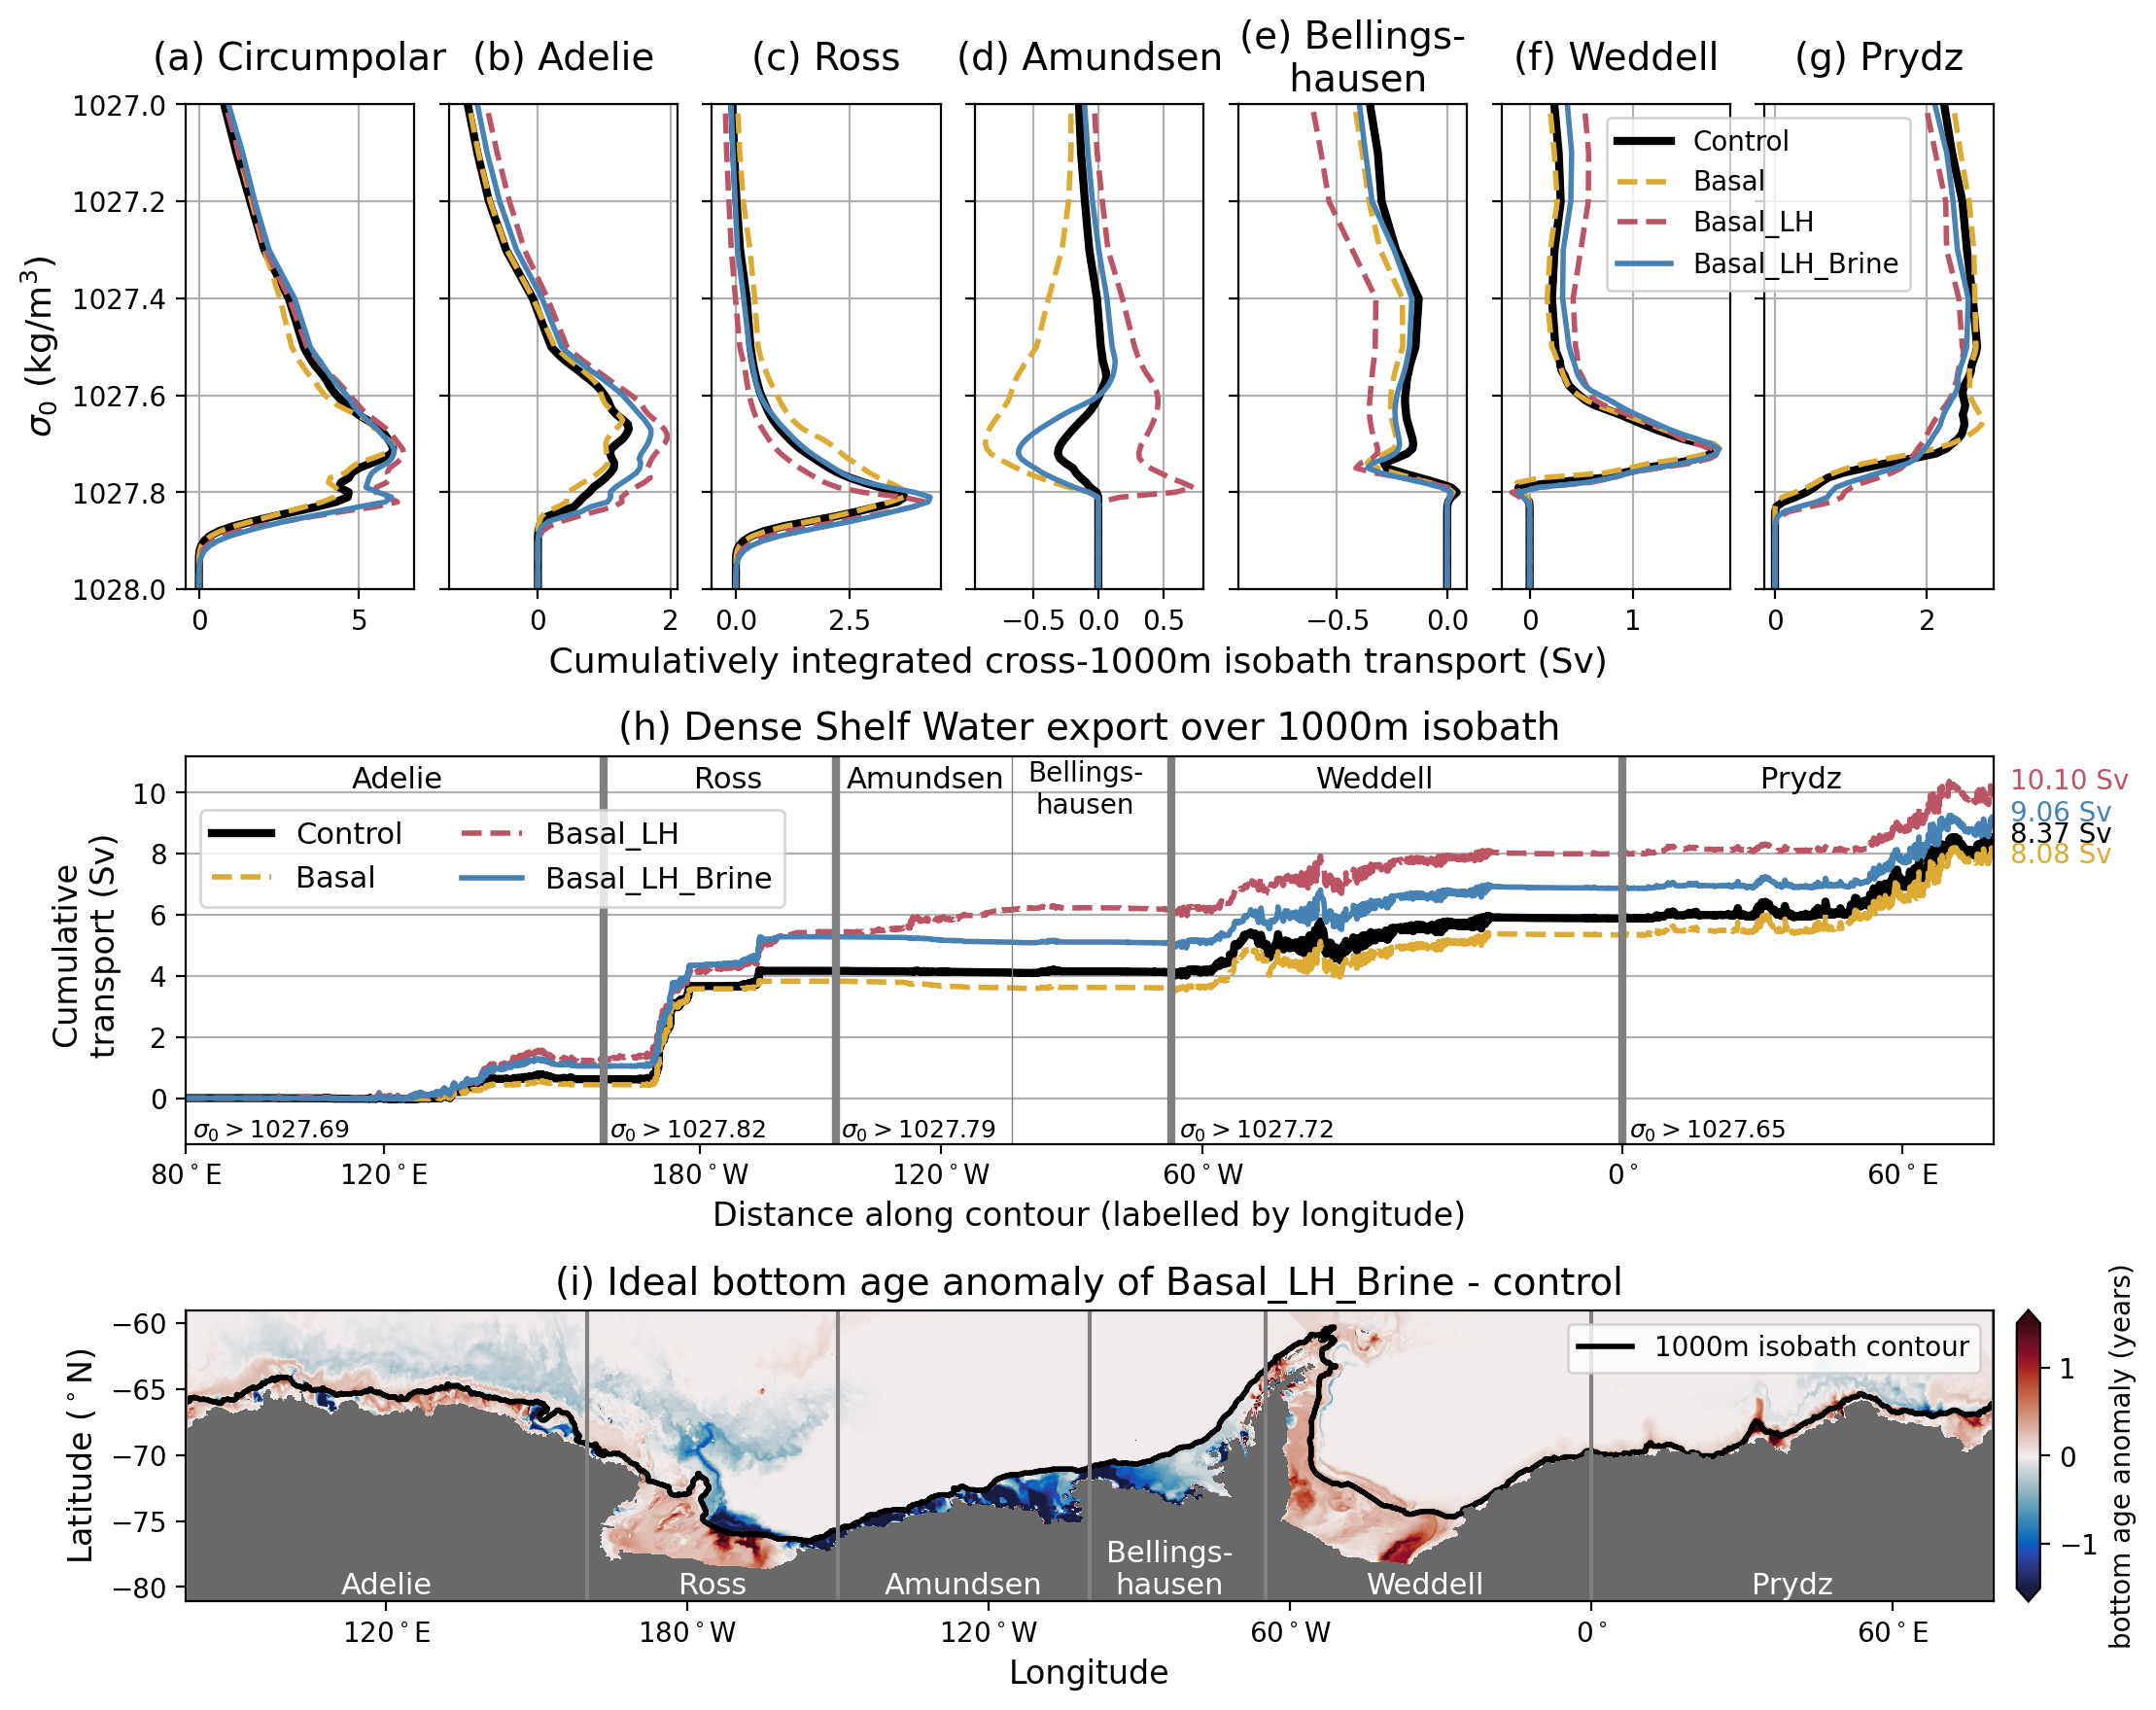

In [41]:
gs = gridspec.GridSpec(3,7, height_ratios = [1,0.8,0.6]) 
fig = plt.figure(figsize = (12,10),dpi = 200)
ax0, ax1, ax2, ax3, ax4, ax4b,ax5,ax6,ax7 = plt.subplot(gs[2,:]), plt.subplot(gs[0,0]), plt.subplot(gs[0,1]), plt.subplot(gs[0,2]),plt.subplot(gs[0,3]),plt.subplot(gs[0,4]),plt.subplot(gs[0,5]),plt.subplot(gs[0,6]),plt.subplot(gs[1,:])

yt_ocean = cc.querying.getvar(control, 'yt_ocean',master_session, n=1, ncfile = 'ocean_grid.nc')
xt_ocean = cc.querying.getvar(control, 'xt_ocean',master_session, n=1, ncfile = 'ocean_grid.nc')
yt_ocean = yt_ocean.sel(yt_ocean=lat_range)

age_plot = (bottom_age_basal-bottom_age_con).plot(ax = ax0, cmap = cm.cm.balance, vmax = 1.5, vmin = -1.5,add_colorbar = False)
cax = plt.axes([0.91,0.11,0.01,0.15])
plt.colorbar(age_plot, cax = cax, label = 'bottom age anomaly (years)',extend = 'both')
ax0.contour(xt_ocean.values, yt_ocean.values,np.abs(mask_x_transport.values)+np.abs(mask_y_transport.values),colors = 'k')
ax0.contourf(ht.xt_ocean, land_mask_lat,land_mask_masked,colors='dimgrey',zorder=2,)

ax0.vlines([-280,-200,-150,-100,-65,0,80],-82,-58,  color = 'grey')
ax0.text(-240, -81, 'Adelie', horizontalalignment='center',verticalalignment='bottom',fontsize = 11,color = 'w')
ax0.text(-175, -81, 'Ross', horizontalalignment='center',verticalalignment='bottom',fontsize = 11,color = 'w')
ax0.text(-125, -81, 'Amundsen', horizontalalignment='center',verticalalignment='bottom',fontsize = 11,color = 'w')
ax0.text(-84, -81, 'Bellings-\nhausen', horizontalalignment='center',verticalalignment='bottom',fontsize = 11,color = 'w')
ax0.text(-33, -81, 'Weddell', horizontalalignment='center',verticalalignment='bottom',fontsize = 11,color = 'w')
ax0.text(40, -81, 'Prydz', horizontalalignment='center',verticalalignment='bottom',fontsize = 11,color = 'w')

# make a fake object for legend, out of the domain
ax0.plot([0,1],[0,1],color = 'k', linewidth = 2,label = '1000m isobath contour')

ax0.set_title('(i) Ideal bottom age anomaly of Basal_LH_Brine - control', fontsize = 14)
ax0.set_ylabel('Latitude ($^\circ$N)', fontsize = 12)
ax0.set_xlabel('Longitude', fontsize = 12)
ax0.set_xticks(np.array([-240,-180,-120,-60,0,60]))
ax0.set_xticklabels(('120$^\circ$E','180$^\circ$W','120$^\circ$W','60$^\circ$W','0$^\circ$','60$^\circ$E'))
ax0.legend(loc = 'upper right')
ax0.set_ylim(min(yt_ocean.values),max(yt_ocean.values))

save_dir = '/g/data/x77/cy8964/basal_mom5-collaborative-project/notebooks/cross_contour/'

for n in np.arange(7):
    #print(n)
    ax = [ax1,ax2,ax3,ax4,ax4b,ax5,ax6][n]
    sector = [slice(0,6002),Adelie, Ross, Am,Be, Weddell, Prydz][n]
    sector_name = ['(a) Circumpolar','(b) Adelie', '(c) Ross', '(d) Amundsen','(e) Bellings-\n hausen', '(f) Weddell', '(g) Prydz'][n]
    for i in np.arange(4):
        ekey = keys[i]
        label = exptdict[ekey]['shortname']
        Nice_label = ekey
        # OPEN FROM SAVED ARRAY
        array = xr.open_dataset(save_dir+label+'_vol_trans_across_contour_binned_last_3yr.nc').vol_trans_across_contour_binned_last_3yr
        color = exptdict[ekey]['colors']
        linestyle = exptdict[ekey]['linestyles']
        linewidth = exptdict[ekey]['linewidth']
        b = (array/1e6).sel(contour_index = sector).sum('contour_index')
        (b.sum('isopycnal_bins') -b.cumsum('isopycnal_bins')).plot(ax = ax, y = 'isopycnal_bins', label = Nice_label,color = color, linestyle = linestyle, linewidth = linewidth)
        print(sector_name, (b.sum('isopycnal_bins') -b.cumsum('isopycnal_bins')).idxmax('isopycnal_bins').values)
    ax.set_ylim(1028.0,1027)
    ax.set_title(sector_name, fontsize = 14, y = 1.06, va = 'center')
    ax.grid()
    if n == 0:
        ax.set_ylabel('$\sigma_0$ (kg/m$^3$)', fontsize = 13)
    else:
        ax.set_ylabel('')
        ax.set_yticklabels('')
    if n ==2:
        ax.set_xlabel('                                             Cumulatively integrated cross-1000m isobath transport (Sv)', fontsize = 13)  
    else:
        ax.set_xlabel('')
    if n ==6:
        ax.legend(loc = 'upper left', bbox_to_anchor = (-0.75,1))

density_sliceAde = slice(1027.69,1030)
density_sliceRos = slice(1027.82,1030)
density_sliceAmBe = slice(1027.79,1030)
density_sliceWe = slice(1027.72,1030)
density_slicePr = slice(1027.65,1030)

for i in np.arange(4):
    ekey = keys[i]
    label = exptdict[ekey]['shortname']
    Nice_label = ekey 
    # OPEN FROM SAVED ARRAY
    array = xr.open_dataset(save_dir+label+'_vol_trans_across_contour_binned_last_3yr.nc').vol_trans_across_contour_binned_last_3yr
    color = exptdict[ekey]['colors']
    linestyle = exptdict[ekey]['linestyles']
    offset = [0,-0.4,0,0][i]
    linewidth = exptdict[ekey]['linewidth']
    #copy array so we can fill it with values from the different density bins for different Antarctic sectors
    array_copy = xr.zeros_like(array.isel(isopycnal_bins = 0))
    for j in np.arange(len(array_copy)):
        if j <= 1270: #border of Adelie and Ross
            array_copy[j] = (10**(-6)*array.sel(isopycnal_bins = density_sliceAde)).sum('isopycnal_bins').values[j]            
        if j <= 2149: #border between Ross and Amundsen
            array_copy[j] = (10**(-6)*array.sel(isopycnal_bins = density_sliceRos)).sum('isopycnal_bins').values[j]
        elif j <= 3338: #border between Bellingshausen and Weddell
            array_copy[j] = (10**(-6)*array.sel(isopycnal_bins = density_sliceAmBe)).sum('isopycnal_bins').values[j]
        elif j <=4798: #border between weddell and prydz
            array_copy[j] = (10**(-6)*array.sel(isopycnal_bins = density_sliceWe)).sum('isopycnal_bins').values[j]
        else:
            array_copy[j] = (10**(-6)*array.sel(isopycnal_bins = density_slicePr)).sum('isopycnal_bins').values[j]
    
    ax7.plot(distance_along_contour,array_copy.cumsum('contour_index'),label = Nice_label, color = color, linestyle = linestyle, linewidth = linewidth)
    ax7.text(distance_along_contour[-1]+0.2,offset + array_copy.cumsum('contour_index')[-1],
             "{:.2f}".format(array_copy.cumsum('contour_index')[-1].values) + ' Sv', color = color)
ax7.set_ylabel('Cumulative \n transport (Sv)', fontsize = 12)
ax7.set_xticks(distance_along_contour[distance_indices.astype(int)[:-1]])
ax7.set_xticklabels(('80$^\circ$E','120$^\circ$E','180$^\circ$W','120$^\circ$W','60$^\circ$W','0$^\circ$','60$^\circ$E'));
ax7.set_xlim(0,distance_along_contour[-1]);
ax7.set_xlabel('Distance along contour (labelled by longitude)', fontsize = 12)

inds= [1270, 2149,  3338, 4798]
ax7.vlines(distance_along_contour[inds],-2,11.2,  color = 'grey',linewidth = 3)
inds= [2803]
ax7.vlines(distance_along_contour[inds],-2,11.2,  color = 'grey',linewidth = 0.5)


# region labels
ax7.text(distance_along_contour[635], 10.4, 'Adelie', horizontalalignment='center',verticalalignment='center',fontsize = 11)
ax7.text(distance_along_contour[1709], 10.4, 'Ross', horizontalalignment='center',verticalalignment='center',fontsize = 11)
ax7.text(distance_along_contour[2500], 10.4, 'Amundsen', horizontalalignment='center',verticalalignment='center',fontsize = 11)
ax7.text(distance_along_contour[3050], 10.1, 'Bellings-\nhausen', horizontalalignment='center',verticalalignment='center',fontsize = 10)
ax7.text(distance_along_contour[3900], 10.4, 'Weddell', horizontalalignment='center',verticalalignment='center',fontsize = 11)
ax7.text(distance_along_contour[5399], 10.4, 'Prydz', horizontalalignment='center',verticalalignment='center',fontsize = 11)

#density bin labels
ax7.text(distance_along_contour[20], -1.1, '$\sigma_0>1027.69$', horizontalalignment='left',verticalalignment='center',fontsize = 9)
ax7.text(distance_along_contour[1290], -1.1, '$\sigma_0>1027.82$', horizontalalignment='left',verticalalignment='center',fontsize = 9)
ax7.text(distance_along_contour[2170], -1.1, '$\sigma_0>1027.79$', horizontalalignment='left',verticalalignment='center',fontsize = 9)
ax7.text(distance_along_contour[3360], -1.1, '$\sigma_0>1027.72$', horizontalalignment='left',verticalalignment='center',fontsize = 9)
ax7.text(distance_along_contour[4820], -1.1, '$\sigma_0>1027.65$', horizontalalignment='left',verticalalignment='center',fontsize = 9)


ax7.set_ylim(-1.5,11.2)
ax7.grid(axis = 'y')
ax7.legend(loc = 'upper left',fontsize = 11, ncol=2, bbox_to_anchor = (0,0.9))
ax7.set_title('(h) Dense Shelf Water export over 1000m isobath',fontsize = 14)

fig.subplots_adjust(hspace = 0.43, wspace = 0.15)

# Print peak circumpolar transport

In [38]:
sector = slice(0,6002)
for i in np.arange(4):
    ekey = keys[i]
    label = exptdict[ekey]['shortname']
    Nice_label = ekey
    # OPEN FROM SAVED ARRAY
    array = xr.open_dataset(save_dir+label+'_vol_trans_across_contour_binned_last_3yr.nc').vol_trans_across_contour_binned_last_3yr
    color = exptdict[ekey]['colors']
    linestyle = exptdict[ekey]['linestyles']
    linewidth = exptdict[ekey]['linewidth']
    b = (array/1e6).sel(contour_index = sector).sum('contour_index')
    if i==0:
        control_maxot = (b.sum('isopycnal_bins') -b.cumsum('isopycnal_bins')).max('isopycnal_bins').values
        control_maxotgt10278 = (b.sum('isopycnal_bins') -b.cumsum('isopycnal_bins')).sel(isopycnal_bins = slice(1027.8,1029)).max('isopycnal_bins').values

        print(label, ': max overturning = ', (b.sum('isopycnal_bins') -b.cumsum('isopycnal_bins')).max('isopycnal_bins').values, 'Sv')
        print(label, ': max overturning at densities greater than 1027.8 = ', (b.sum('isopycnal_bins') -b.cumsum('isopycnal_bins')).sel(isopycnal_bins = slice(1027.8,1029)).max('isopycnal_bins').values, 'Sv')
    else:
        print(label, ': max overturning = ', (b.sum('isopycnal_bins') -b.cumsum('isopycnal_bins')).max('isopycnal_bins').values, 'Sv', 
              'This is ',(b.sum('isopycnal_bins') -b.cumsum('isopycnal_bins')).max('isopycnal_bins').values/control_maxot*100,'% of control')
        print(label, ': max overturning at densities greater than 1027.8 = ', (b.sum('isopycnal_bins') -b.cumsum('isopycnal_bins')).sel(isopycnal_bins = slice(1027.8,1029)).max('isopycnal_bins').values, 'Sv', 
              'This is ',(b.sum('isopycnal_bins') -b.cumsum('isopycnal_bins')).sel(isopycnal_bins = slice(1027.8,1029)).max('isopycnal_bins').values/control_maxotgt10278*100,'% of control')
        
    print('----')


control : max overturning =  6.0587697225466846 Sv
control : max overturning at densities greater than 1027.8 =  4.643927645718627 Sv
----
basal_nogade : max overturning =  6.067199553408136 Sv This is  100.13913436633976 % of control
basal_nogade : max overturning at densities greater than 1027.8 =  4.216931641470786 Sv This is  90.80528300992154 % of control
----
basal : max overturning =  6.396001885857641 Sv This is  105.56601717434488 % of control
basal : max overturning at densities greater than 1027.8 =  6.197081869889497 Sv This is  133.4448411486938 % of control
----
basal_gade_brine : max overturning =  6.081979880330147 Sv This is  100.3830836761643 % of control
basal_gade_brine : max overturning at densities greater than 1027.8 =  6.012221862865202 Sv This is  129.46415882271648 % of control
----


# Print peak Adelie and Ross transport

In [41]:
for j in np.arange(2):
    sector = [Adelie, Ross][j]
    label = ['Adelie','Ross'][j]
    print('-----',label,'-----')
    for i in np.arange(4):
        ekey = keys[i]
        label = exptdict[ekey]['shortname']
        Nice_label = ekey
        # OPEN FROM SAVED ARRAY
        array = xr.open_dataset(save_dir+label+'_vol_trans_across_contour_binned_last_3yr.nc').vol_trans_across_contour_binned_last_3yr
        color = exptdict[ekey]['colors']
        linestyle = exptdict[ekey]['linestyles']
        linewidth = exptdict[ekey]['linewidth']
        b = (array/1e6).sel(contour_index = sector).sum('contour_index')
        if i==0:
            control_maxot = (b.sum('isopycnal_bins') -b.cumsum('isopycnal_bins')).max('isopycnal_bins').values
#            control_maxotgt10278 = (b.sum('isopycnal_bins') -b.cumsum('isopycnal_bins')).sel(isopycnal_bins = slice(1027.8,1029)).max('isopycnal_bins').values
    
            print(label, ': max overturning = ', (b.sum('isopycnal_bins') -b.cumsum('isopycnal_bins')).max('isopycnal_bins').values, 'Sv')
#            print(label, ': max overturning at densities greater than 1027.8 = ', (b.sum('isopycnal_bins') -b.cumsum('isopycnal_bins')).sel(isopycnal_bins = slice(1027.8,1029)).max('isopycnal_bins').values, 'Sv')
        else:
            print(label, ': max overturning = ', (b.sum('isopycnal_bins') -b.cumsum('isopycnal_bins')).max('isopycnal_bins').values, 'Sv', 
                  'This is ',(b.sum('isopycnal_bins') -b.cumsum('isopycnal_bins')).max('isopycnal_bins').values/control_maxot*100,'% of control')
            # print(label, ': max overturning at densities greater than 1027.8 = ', (b.sum('isopycnal_bins') -b.cumsum('isopycnal_bins')).sel(isopycnal_bins = slice(1027.8,1029)).max('isopycnal_bins').values, 'Sv', 
            #       'This is ',(b.sum('isopycnal_bins') -b.cumsum('isopycnal_bins')).sel(isopycnal_bins = slice(1027.8,1029)).max('isopycnal_bins').values/control_maxotgt10278*100,'% of control')
            
        print('----')


----- Adelie -----
control : max overturning =  1.3731829398679363 Sv
----
basal_nogade : max overturning =  1.2805970359028493 Sv This is  93.25756960146975 % of control
----
basal : max overturning =  1.952287693018551 Sv This is  142.17244012704595 % of control
----
basal_gade_brine : max overturning =  1.7090637848401955 Sv This is  124.46002169270776 % of control
----
----- Ross -----
control : max overturning =  3.7150914580561483 Sv
----
basal_nogade : max overturning =  3.767983466266025 Sv This is  101.42370675949796 % of control
----
basal : max overturning =  4.1804688584721585 Sv This is  112.52667412552772 % of control
----
basal_gade_brine : max overturning =  4.278899831694238 Sv This is  115.17616403266399 % of control
----


# Back of the envelope calculation of age change

In [54]:
# open basal transport
start_time = '1907-01-01'
end_time = '1909-12-31'
time_slice = slice(start_time,end_time)

basal_fwflx = cc.querying.getvar(basal_gade_brine, 'basal_fwflx',basal_melt_session,start_time = start_time,
                            end_time = end_time).sel(time = time_slice,yt_ocean=lat_range)
area_t = cc.querying.getvar(basal_gade_brine, 'area_t',basal_melt_session,n=-1)

def shelf_mask_isobath(var):
    '''
    Masks ACCESS-OM2-01 variables by the region polewards of the 1000m isobath as computed using 
    a script contributed by Adele Morrison.
    Only to be used with ACCESS-OM2-0.1 output!
    '''
    contour_file = np.load('/g/data/ik11/grids/Antarctic_slope_contour_1000m.npz')
    
    shelf_mask = contour_file['contour_masked_above']
    yt_ocean = contour_file['yt_ocean']
    xt_ocean = contour_file['xt_ocean']
    
    # in this file the points along the isobath are given a positive value, the points outside (northwards) 
    # of the isobath are given a value of -100 and all the points on the continental shelf have a value of 0 
    # so we mask for the 0 values 
    shelf_mask[np.where(shelf_mask!=0)] = np.nan
    shelf_mask = shelf_mask+1
    shelf_map  = np.nan_to_num(shelf_mask)
    shelf_mask = xr.DataArray(shelf_mask, coords = [('yt_ocean', yt_ocean), ('xt_ocean', xt_ocean)])
    shelf_map  = xr.DataArray(shelf_map,  coords = [('yt_ocean', yt_ocean), ('xt_ocean', xt_ocean)])
    
    # then we want to multiply the variable with the mask so we need to account for the shape of the mask. 
    # The mask uses a northern cutoff of 59S.
    masked_var = var.sel(yt_ocean = slice(-90, -59.03)) * shelf_mask

    return masked_var, shelf_map
    
masked_area, shelf_map, = shelf_mask_isobath(area_t)

In [71]:
# compute area of Antarctic shelf ocean from area*max depth
(masked_area*ht).sum().values 

array(1.3999135e+15, dtype=float32)

In [72]:
# compute mass added in 10 years from intregral of basal_fwflux of 1 year *10 years * s_per_month*area basal is added to
(basal_fwflx.isel(time = np.arange(12))*masked_area).sum().values*30*24*3600*10 #kg/m^3 * m^3

1.42017712128e+16

In [76]:
vol_basal_fwflx = 1.42017712128e16/1030 #m^3/10yr

In [77]:
vol_shelf = 1.3999135e15 #m^3

In [78]:
vol_basal_fwflx/vol_shelf

0.009849270966433255

Suggests 1% of continetal shelf water by volume comes from basal melt if all is added to shelf and nothing lost. Assuming all of this zero age goes to the bottom, that would indicate 1% ish less age than normal. Clearly our age changes are bigger than that (~1 year anomaly over 10 year run) so age changes dominanted by circulation changes rather than simply adding volume.

